### Project and data are based on a free, online course of machine learning https://www.coursera.org/learn/machine-learning. I wholeheartedly recommend this! 

## I will show how do it in Python:
    + neural networks,
    + forward and backward propagation,
    + visualization of hidden units.


In [1]:
import numpy as np
import pandas
import scipy.io
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize
import math 
import warnings
import sys

# ignore warnings
warnings.filterwarnings('ignore')

'''
# write packages and python version to file
! python -m pip list > packages_versions.txt
# a append to file
with open('packages_versions.txt', 'a') as f:
    f.write('Python version ' + str(sys.version))
''';

In [2]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_gradient(z):
    '''
    Returns gradient of sigmoid function.
    '''
    return sigmoid(z) * (1 - sigmoid(z))

def con_ones(X):
    m = len(X)
    ones = np.ones((m,1))
    return np.concatenate((ones, X), 1)


def predict(X, *thetas):
    '''
    Predicts class for given thetas.
    '''
    i = 0
    m = X.shape[0]
    for theta in thetas:
        if i != 0:
            X = sigmoid(X)           
        X = con_ones(X)
        X = X @ theta.T
        i += 1            
    hx = sigmoid(X)
    pred = np.argmax(hx, axis = 1)
    pred = np.reshape((pred + 1),(m,1))
    return pred

def plot_numbers(X, size, range_):
    z = np.ones((20*size + size - 1, 20*size + size - 1))
    choosed = random.sample(range(range_), size ** 2)
    for no_pic in range(size ** 2):
        pic = X[choosed[no_pic]]
        x, y = divmod(no_pic, size)
        for i in range(400):
            d, r = divmod(i,20)
            z[r + 20*x + x][d + 20*y + y] = pic[i]
    if size == 1:
        return z, choosed[0]
    else:
        return z
    
def pack(flat_theta, layers):
    '''
    Changes flat array to list of arrays, which shapes are from layers.
    '''
    sub_thetas = []
    from_ = 0
    for no_theta in range(1, len(layers)):     
        prev = layers[no_theta - 1] + 1
        cur = layers[no_theta]
        temp = flat_theta[from_:from_ + prev*cur]
        temp = np.reshape(temp, (cur, prev), 'F')
        sub_thetas.append(temp)
        from_ += prev*cur        
    return sub_thetas 
        
        
cost_history = []
def gradient_cost_fun(flat_theta, X,Y, lambda_, layers):
    '''
    Computes cost function and gradient for neural network,
    using forward and backward propagation.
    Provides cost history.
    '''
    global cost_history
    thetas = pack(flat_theta, layers)
    
    #forward propagation
    Z = {}
    A = {}  
    i = 0
    reg = 0
    for theta in thetas:
        reg += np.sum(theta[:,1:]**2)
        if i != 0:
            X = sigmoid(X)
        X = con_ones(X)
        A[i+1] = X
        X = X @ theta.T
        Z[i+2] = X
        i += 1
        
    A[i+1] = sigmoid(X)     
    h_theta = A[i+1]
    reg = lambda_/(2*m) * reg      
    no_reg = np.sum(-Y.T * np.log(h_theta) - (1-Y.T) * np.log(1 - h_theta))/m  
    J = reg + no_reg
    
    #backward propagation
    d = {}
    D = {}
    delta = A[i+1].T - Y
    d[i+1] = delta
    for j in range(len(thetas), 1, -1):
        temp = d[j+1].T @ thetas[j-1] * con_ones(sigmoid_gradient(Z[j]))
        d[j] = temp[:, 1:].T
        
    for key, item in d.items():
        temp = thetas[key-2]
        mask = np.ones(temp.shape)
        mask[:,0] = 0
        D[key-1] = (d[key] @ A[key-1] + lambda_ * temp * mask)/m
    gradients = np.array([])
    for k, it in sorted(D.items(), key = lambda x: x[0]):
        gradients = np.concatenate((gradients, it.flatten('F')))
    cost_history.append(J)
    return J, gradients


def random_init_thetas(L_in, L_out):
    '''
    Randomly innitial theta.
    theta.shape := (L_out, L_in + 1)
    '''
    epsilon_init = math.sqrt(6)/(math.sqrt(L_in + L_out))
    return np.random.rand(L_out, L_in + 1) * 2*epsilon_init - epsilon_init

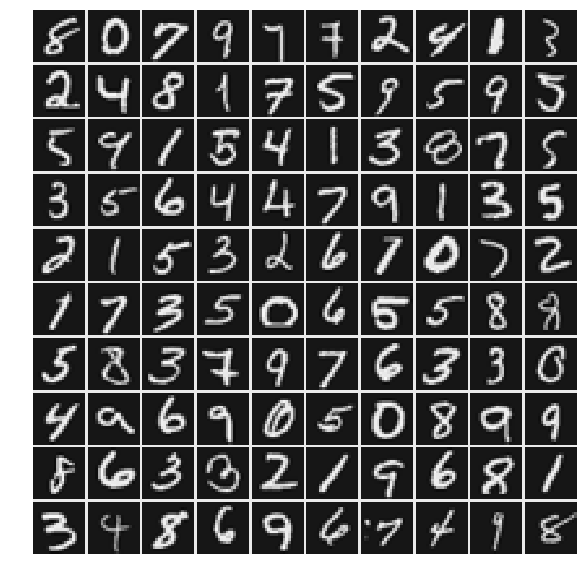

In [3]:
# Load all needed data
mat = scipy.io.loadmat('ex4data1.mat')
X = mat['X']
Y = mat['y']

weights = scipy.io.loadmat('ex4weights')
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

# Plot some examples
z = plot_numbers(X, 10, 5000)
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(z, cmap="gray");

In [4]:
# Let's do few tests

# We have to work on flatten data, because minimize funtion requires it.
t1 = Theta1.flatten('F')
t2 = Theta2.flatten('F')
T = np.concatenate((t1, t2))


layers = (400, 25, 10)
m = Y.shape[0]
Y_trans = np.zeros((10, m))
for k in range(m):
    Y_trans[Y[k] - 1,k] = 1 

    
lambda_ = 0
Jtest1, grad_test1  = gradient_cost_fun(T, X,Y_trans, lambda_, layers)

assert np.allclose(Jtest1, 0.287629)
assert np.allclose(grad_test1[:6],
                   np.array([6.1871e-05, 9.388e-05,-0.00019259,-0.00016849, 0.00034868,0.00023051]))

lambda_ = 1
Jtest2, grad_test2  = gradient_cost_fun(T, X,Y_trans, lambda_, layers)

assert np.allclose(Jtest2, 0.383770)
assert np.allclose(grad_test2[-6:],
                   np.array([-0.0010498, 0.00033512, -0.00064783, 0.00085755, 0.00093069, 0.00050783])
                  , rtol=10e-5, atol = 10e-8)

In [5]:
input_layer_size  = 400
# You can change hidden_layer_size only
hidden_layer_size = 25
num_labels = 10

# Randomly full our thetas (weights)
initial_Theta1_ori = random_init_thetas(input_layer_size, hidden_layer_size)
initial_Theta1 = initial_Theta1_ori.flatten('F')

initial_Theta2_ori = random_init_thetas(hidden_layer_size, num_labels)
initial_Theta2 = initial_Theta2_ori.flatten('F')
initial_Theta = np.concatenate((initial_Theta1, initial_Theta2)) 
# #units in next layers
layers = (input_layer_size, hidden_layer_size, num_labels)

lambda_ = 3
Nfeval = 1

cost_history = []
counter = 0

def callbackF(Xi):
    '''
    Gives callback information about last cost value and iteration number.
    '''
    global Nfeval
    if Nfeval % 100 == 0:
        print("Iteration:", Nfeval,"Cost:", cost_history[-1])
    Nfeval += 1

#Now minimize uses this same function for cost and grad (jac)!
res = minimize(gradient_cost_fun, initial_Theta, jac = True, args = (X, Y_trans, lambda_, layers),
               method = 'CG', callback=callbackF, options = {'maxiter' : 3000})

#Transform flat_array to list of array
thetas = pack(res.x, layers)
Theta1_min = thetas[0]
Theta2_min = thetas[1]

Iteration: 100 Cost: 0.590658748651
Iteration: 200 Cost: 0.571069430173
Iteration: 300 Cost: 0.565566477284
Iteration: 400 Cost: 0.563061997107
Iteration: 500 Cost: 0.560595671103
Iteration: 600 Cost: 0.559443624794
Iteration: 700 Cost: 0.558956840354
Iteration: 800 Cost: 0.558545083468
Iteration: 900 Cost: 0.558378524064
Iteration: 1000 Cost: 0.558274377352
Iteration: 1100 Cost: 0.558091878917
Iteration: 1200 Cost: 0.557541623284
Iteration: 1300 Cost: 0.557440114596
Iteration: 1400 Cost: 0.557283082048
Iteration: 1500 Cost: 0.557040142538
Iteration: 1600 Cost: 0.556923593872
Iteration: 1700 Cost: 0.556843323445
Iteration: 1800 Cost: 0.556745936112
Iteration: 1900 Cost: 0.556690981374
Iteration: 2000 Cost: 0.556666544211
Iteration: 2100 Cost: 0.556655297865
Iteration: 2200 Cost: 0.55664986808


In [6]:
print('Accuracy on training set =', 100*np.mean(predict(X, Theta1_min, Theta2_min) == Y),'proc')

Accuracy on training set = 97.88 proc


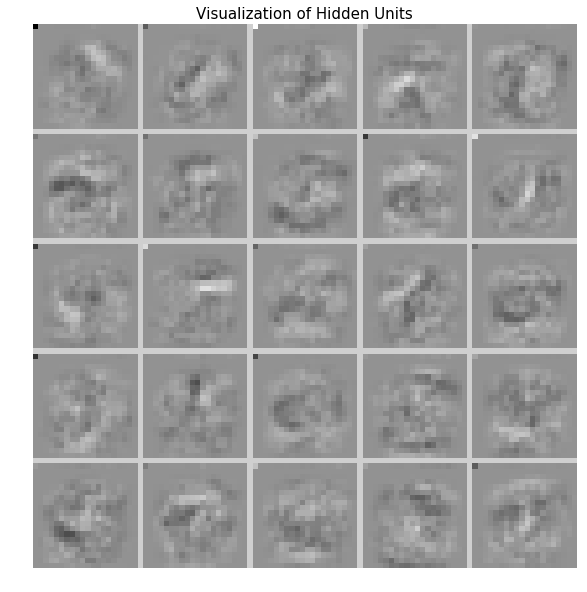

In [7]:
z1 = plot_numbers(Theta1_min, 5, 25)
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(z1, cmap="gray")
plt.title('Visualization of Hidden Units', size = 15);